In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Download Dataset into Drive

In [0]:
import os

In [0]:
os.chdir('/root')

In [0]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
!ls

In [0]:
import json
token = {"username":"kaleem014","key":"3187f50b27a6807cebc3c8ec1b006105"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
os.chdir('/gdrive/My Drive')
#!kaggle competitions download -c code-marathon-ml

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!rm -rf './data'

In [0]:
os.mkdir('data')

In [0]:
os.chdir('data')

In [0]:
os.mkdir('code_m')

In [0]:
!kaggle competitions download -c code-marathon-ml

data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!ls

code_m	data.zip


In [0]:
!mv data.zip code_m/

In [0]:
!ls

code_m


In [0]:
!unzip code_m/data.zip

# Get Dataframe for Train, Validation and Test

In [0]:
os.chdir('/gdrive/My Drive/data/data')
import pandas as pd
train_df = pd.read_csv('./train.csv')
test_df =  pd.read_csv('./test.csv')

In [4]:
train_df.head()

,image_name,n_sides
0,0.png,5
1,1.png,8
2,2.png,4
3,3.png,7
4,4.png,4


In [5]:
test_df.head()

,image_name
0,0test.png
1,1test.png
2,2test.png
3,3test.png
4,4test.png


#Train, Validation and Test Generator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.0,
    height_shift_range = 0.0,
    shear_range = 0.0,
    zoom_range = 0.0,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1/255.0,
    validation_split = 0.2
)

In [8]:
train_generator = data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = "./train/",
    x_col = "image_name",
    y_col = "n_sides",
    color_mode = 'rgb',
    subset = "training",
    batch_size = 8,
    seed = 4,
    shuffle = True,
    class_mode = "other",
    target_size = (256, 256)
)

Found 14746 images.


In [9]:
validation_generator = data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = "./train/",
    x_col = "image_name",
    y_col = "n_sides",
    color_mode = 'rgb',
    subset = "validation",
    batch_size = 8,
    seed = 4,
    shuffle = False,
    class_mode = "other",
    target_size = (256, 256)
)

Found 3686 images.


# ResNet18 Pretrained


In [0]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-xncl5p26
  Stored in directory: /tmp/pip-ephem-wheel-cache-mu8q3_wr/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
from classification_models.resnet import ResNet18

In [0]:
ResModel = ResNet18(weights ='imagenet', include_top = False, input_shape = (256, 256, 3))

44924928/44920640 [==============================] - 1s 0us/step


In [0]:
import keras
x = ResModel.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation = 'relu')(x)
predictions = keras.layers.Dense(1, activation = 'linear')(x)
res_model = keras.models.Model(inputs = ResModel.input, outputs = predictions)

In [0]:
adam = keras.optimizers.Adam(lr = 0.001)
res_model.compile(optimizer = adam, loss = 'mean_squared_error')
res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALIDATION = validation_generator.n//validation_generator.batch_size
history = res_model.fit_generator(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs = 35,
    validation_data = validation_generator,
    validation_steps = STEP_SIZE_VALIDATION,
)

Epoch 1/35
1843/1843 [==============================] - 509s 276ms/step - loss: 0.0282 - val_loss: 0.0213
Epoch 2/35
1843/1843 [==============================] - 530s 287ms/step - loss: 0.0247 - val_loss: 0.0275
Epoch 3/35
1843/1843 [==============================] - 530s 288ms/step - loss: 0.0250 - val_loss: 0.0550
Epoch 4/35
1843/1843 [==============================] - 531s 288ms/step - loss: 0.0254 - val_loss: 0.0180
Epoch 5/35
1843/1843 [==============================] - 529s 287ms/step - loss: 0.0234 - val_loss: 0.0234
Epoch 6/35
1843/1843 [==============================] - 525s 285ms/step - loss: 0.0249 - val_loss: 0.0207
Epoch 7/35
1843/1843 [==============================] - 486s 264ms/step - loss: 0.0244 - val_loss: 0.0407
Epoch 8/35
1843/1843 [==============================] - 472s 256ms/step - loss: 0.0228 - val_loss: 0.0194
Epoch 9/35
1843/1843 [==============================] - 465s 252ms/step - loss: 0.0245 - val_loss: 0.0194
Epoch 10/35
1843/1843 [=======================

In [0]:
res_model.save('Res18_PolygonToSides_Aug_64_50.h5')

In [11]:
import tensorflow as tf
model = tf.keras.models.load_model('Res18_PolygonToSides_Aug_64_50.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalizationV1)  (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [16]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

Using TensorFlow backend.


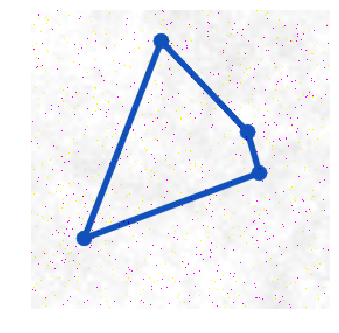

array([[4.0525618]], dtype=float32)

In [22]:
model.predict(load_image('./test/10000test.png'))

In [0]:
test_df['n_sides'] = None
test_df.head()

,image_name,n_sides
0,0test.png,None
1,1test.png,None
2,2test.png,None
3,3test.png,None
4,4test.png,None


In [0]:
test_datagenerator = ImageDataGenerator(rescale = 1/255.0)
test_generator = test_datagenerator.flow_from_dataframe(
    dataframe = test_df,
    directory = './test/',
    x_col = 'image_name',
    y_col = 'n_sides',
    color_mode = 'rgb',
    batch_size = 8,
    seed = 4,
    shuffle = False,
    class_mode = None,
    target_size = (256, 256)
)

Found 16384 images.


In [0]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
prediction = model.predict_generator(
    test_generator,
    steps = STEP_SIZE_TEST
)

In [0]:
prediction

array([[2.9690063],
       [6.903599 ],
       [3.98131  ],
       ...,
       [2.9846623],
       [3.9588873],
       [2.974278 ]], dtype=float32)

In [0]:
import math
for i in range(len(prediction)):
    prediction[i] = int(prediction[i]+0.50)
test_df['n_sides'] = prediction
test_df.head()

,image_name,n_sides
0,0test.png,3.0
1,1test.png,7.0
2,2test.png,4.0
3,3test.png,3.0
4,4test.png,3.0


In [0]:
prediction

array([[3.],
       [7.],
       [4.],
       ...,
       [3.],
       [4.],
       [3.]], dtype=float32)

In [0]:
test_df.to_csv('./result.csv', index = False)

In [0]:
!ls

Res18_PolygonToSides_64_10.h5	   Res18_PolygonToSides_Aug_64_50.h5  test.csv
Res18_PolygonToSides_64_15.h5	   result.csv			      train
Res18_PolygonToSides_Aug_64_13.h5  test				      train.csv


In [0]:
!kaggle competitions submit -c code-marathon-ml -f result.csv -m "Message"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 489, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2793, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2411, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2417, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_d